# Visualize the healthy probability distribution across controls and treatments

In the notebook, we create ridge plots for visualizing probability distributions for compounds applied to the various models. We also create a scatterplot with the cell count per plate/model and compound and the median predicted probabilities.

## Import libraries

In [1]:
suppressPackageStartupMessages(suppressWarnings(library(ggplot2))) # plotting
suppressPackageStartupMessages(suppressWarnings(library(dplyr))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(ggridges))) # ridge line plots
suppressPackageStartupMessages(suppressWarnings(library(RColorBrewer))) # color palettes
suppressPackageStartupMessages(suppressWarnings(library(arrow))) # parquet files
suppressPackageStartupMessages(suppressWarnings(library(ggrepel))) # add names to plots

## Create directory for outputs

In [2]:
# Specify the path for the figures directory
figures_dir <- "./figures"

# Create the figures directory if it doesn't exist
if (!dir.exists(figures_dir)) {
  dir.create(figures_dir, recursive = TRUE)
}

## Load in the predicted probabilities

In [3]:
# Load in the probabilities
combined_probabilities_path <- file.path(
    "./performance_metrics/batch1_compound_predictions.parquet"
)

# Read in the data from the parquet file
combined_probabilities_df <- arrow::read_parquet(
    combined_probabilities_path
)

# Load the plate name mapping file
plate_name_mapping_path <- file.path(
    "./batch1_plate_name_mapping.csv"
)

plate_name_mapping <- read.csv(plate_name_mapping_path)

# Map the model_name to the new name
combined_probabilities_df <- combined_probabilities_df %>%
    left_join(plate_name_mapping, by = c("model_name" = "original")) %>%
    mutate(model_name = ifelse(!is.na(mapped), mapped, model_name)) %>%
    select(-mapped)

# Display dimensions and a preview of the data
dim(combined_probabilities_df)
head(combined_probabilities_df, 2)

[1] 191900     23

Metadata_WellRow,Metadata_WellCol,Metadata_heart_number,Metadata_cell_type,Metadata_heart_failure_type,Metadata_treatment,Metadata_Pathway,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_Cells_Location_Center_X,⋯,Metadata_Plate,Metadata_Well,Metadata_Cells_Number_Object_Number,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_Nuclei_Number_Object_Number,Metadata_Site,predicted_probas,model_type,model_name
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>
B,3,19,failing,dilated_cardiomyopathy,UCD-0159256,Apoptosis,704.2607,247.5338,657.2745,⋯,localhost240928120001,B03,1,1,6,6,f19,0.8811497,final,combined_batch1
B,3,19,failing,dilated_cardiomyopathy,UCD-0159256,Apoptosis,597.4425,520.2014,565.4729,⋯,localhost240928120001,B03,1,1,7,7,f17,0.9842477,final,combined_batch1


## Generate ridge plot for only treatments facet by plate and colored by pathway

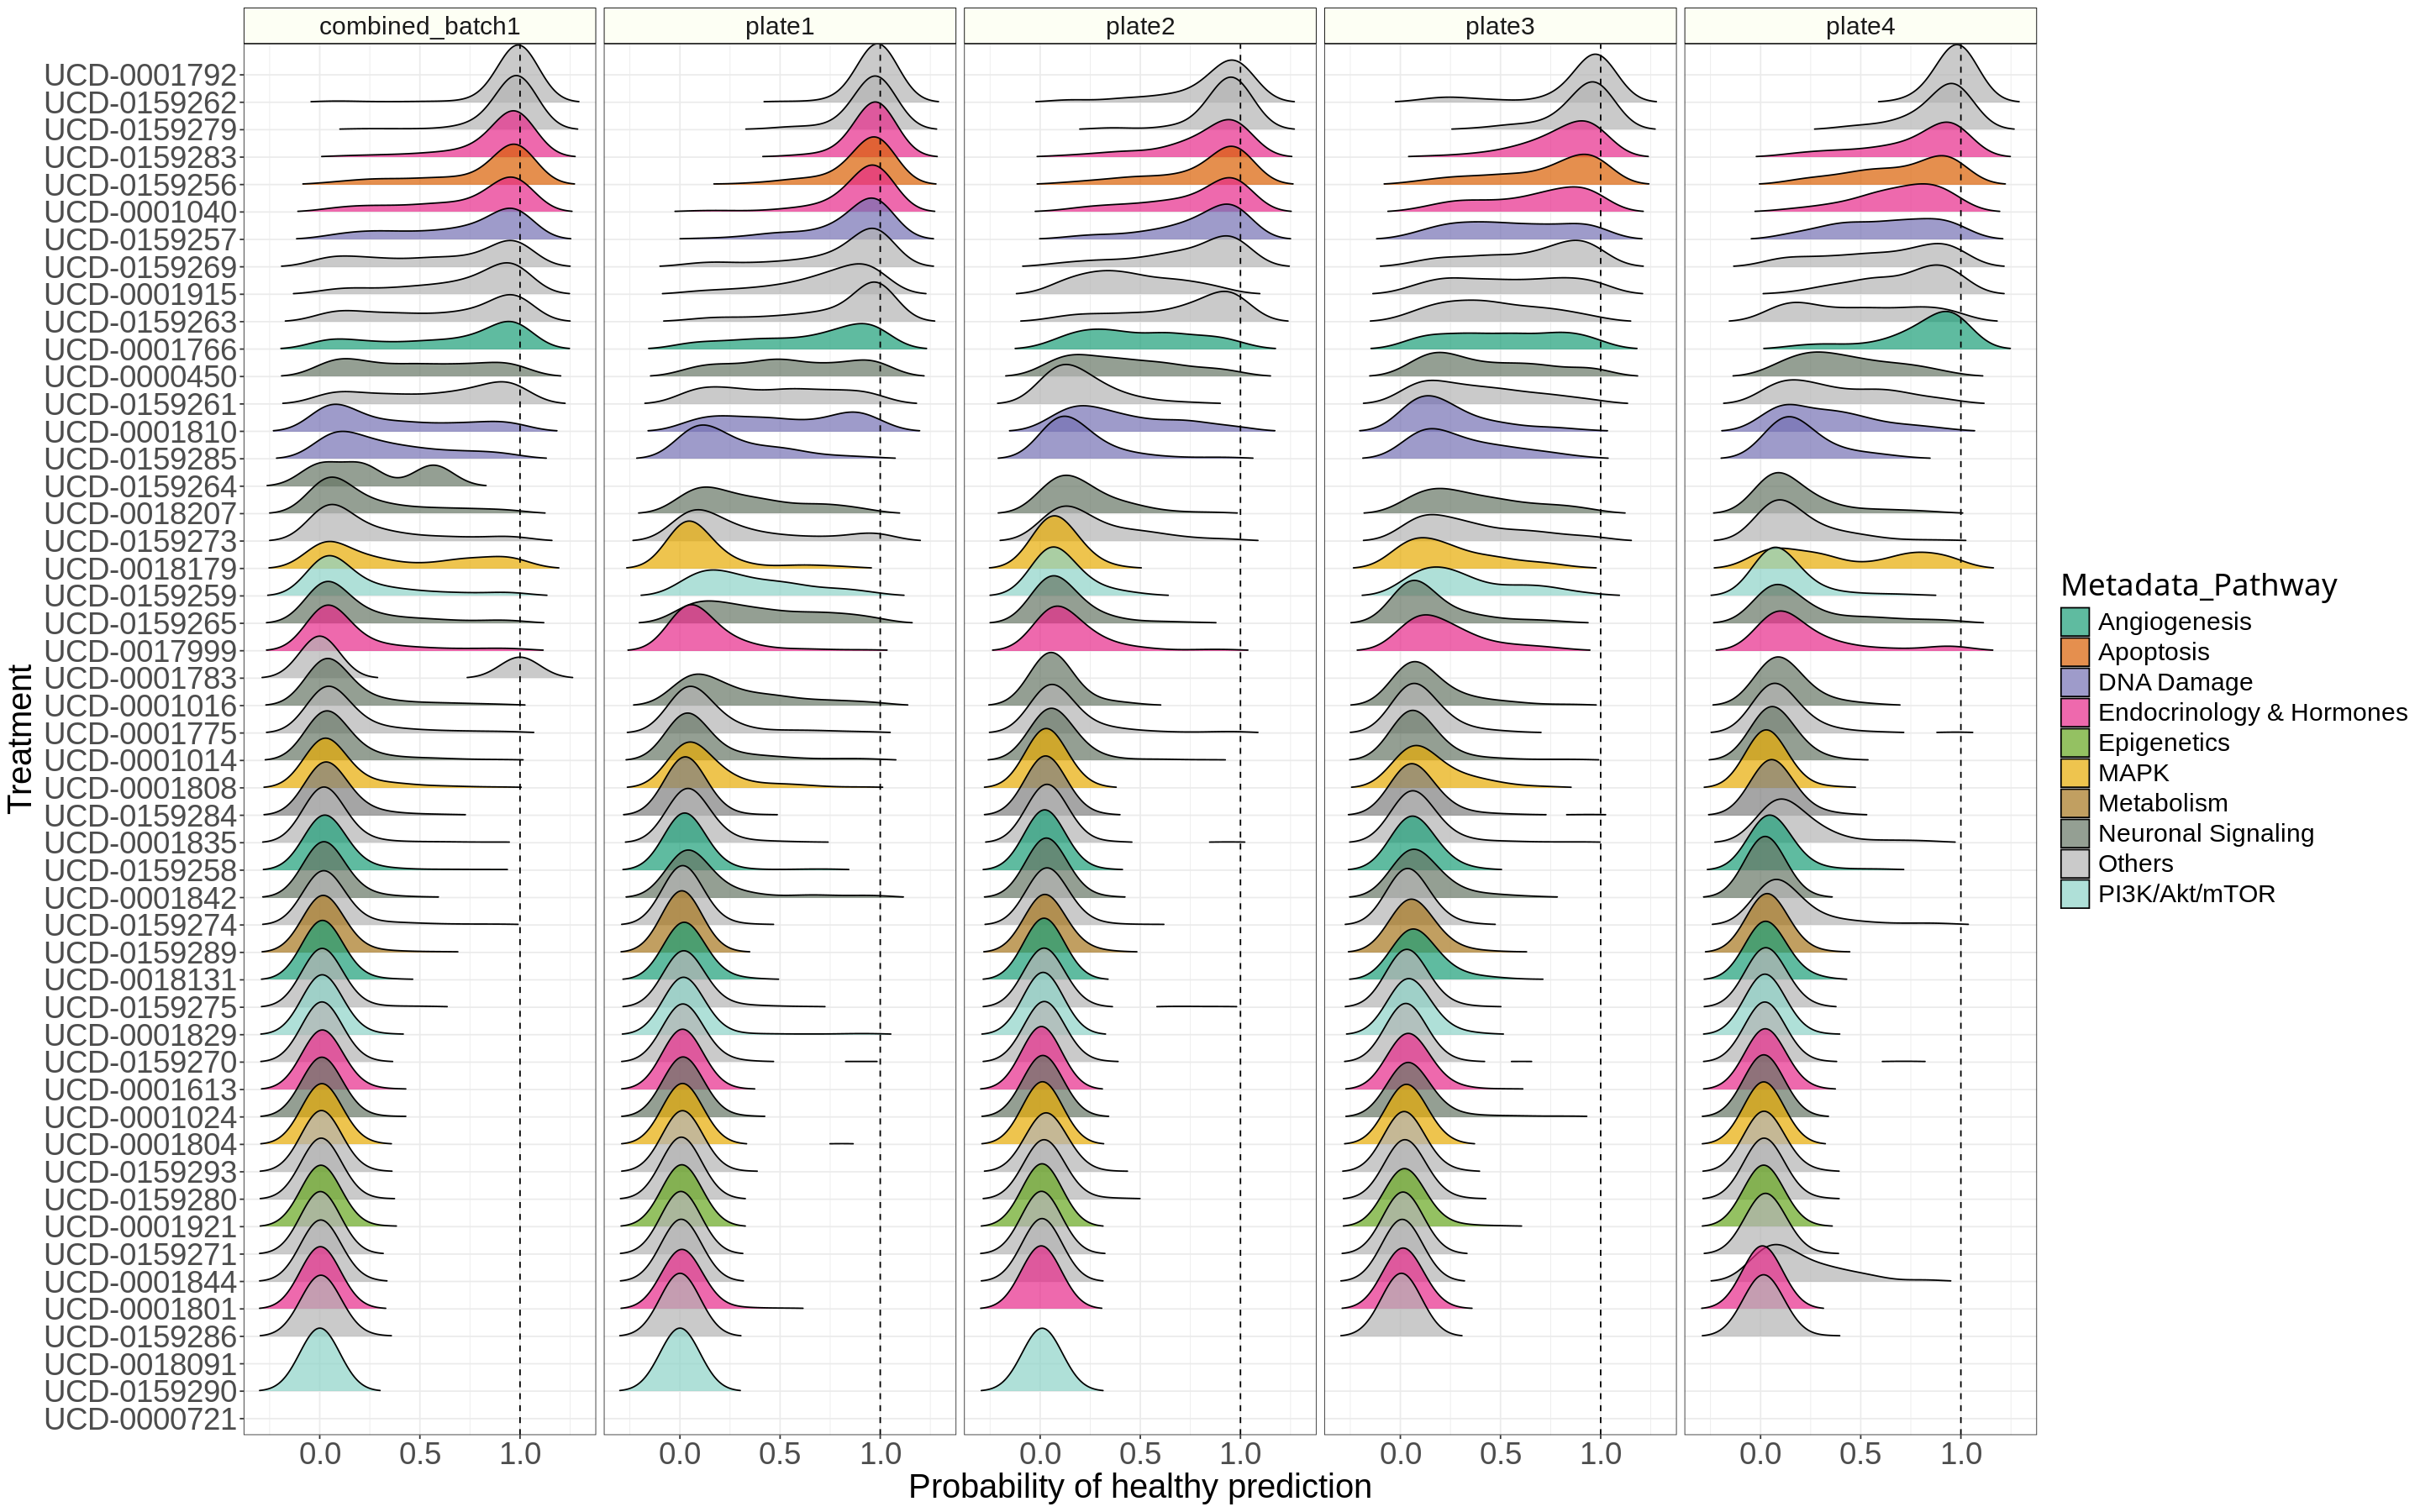

In [4]:
# Custom color palette inspired by Dark2
custom_palette <- c(
  "Angiogenesis" = "#1b9e77",
  "Apoptosis" = "#d95f02",
  "DNA Damage" = "#7570b3",
  "Endocrinology & Hormones" = "#e7298a",
  "Epigenetics" = "#66a61e",
  "MAPK" = "#e6ab02",
  "Metabolism" = "#a6761d",
  "Neuronal Signaling" = "#667665",
  "Others" = "#b3b3b3",
  "PI3K/Akt/mTOR" = "#8dd3c7",
  "Stem Cells &  Wnt" = "#fb8072"
)

# Filter out shuffle models
filtered_df <- combined_probabilities_df %>% filter(model_type != "shuffled")

# Step 1: Calculate the median Healthy_probas for each treatment (you can use mean instead)
treatment_order <- filtered_df %>%
  group_by(Metadata_treatment) %>%
  summarise(median_healthy_proba = median(predicted_probas)) %>%
  arrange(desc(median_healthy_proba))  # Sort in descending order of median

# Step 2: Reorder the 'Metadata_treatment' factor levels in reverse order for top-to-bottom plotting
filtered_df <- filtered_df %>%
  mutate(Metadata_treatment = factor(Metadata_treatment, levels = rev(treatment_order$Metadata_treatment)))

# Step 3: Create the ridge plot with reordered treatments
height <- 15
width <- 24
options(repr.plot.width = width, repr.plot.height = height)

# Create a ridge plot excluding DMSO and using all other treatments on the y-axis
ridge_plot_non_DMSO <- ggplot(filtered_df, aes(x = predicted_probas, y = Metadata_treatment, fill = Metadata_Pathway)) +
  geom_density_ridges(alpha = 0.7, scale = 2.25, rel_min_height = 0.01, bandwidth = 0.1) +  # Ridges colored by Pathway
  geom_vline(xintercept = 1, linetype = "dashed", color = "black") +
  scale_x_continuous(breaks = seq(0, 1, 0.5)) +
  labs(x = "Probability of healthy prediction", y = "Treatment", color = "Pathway") +  # Update axis labels
  scale_fill_manual(values = custom_palette) +  # Use the custom color palette
  theme_bw() +
  theme(
    legend.position = "right",  # Position the legend on the right
    legend.title = element_text("Pathway", size = 22),
    axis.text = element_text(size = 22),
    axis.text.x = element_text(size = 22),
    axis.title = element_text(size = 24),
    strip.text = element_text(size = 18),
    strip.background = element_rect(
      colour = "black",
      fill = "#fdfff4"
    ),
    legend.text = element_text(size = 18),  # Adjust legend text size if needed
    legend.key.size = unit(1.5, "lines")  # Adjust the size of the legend keys
  ) +
  facet_wrap(~ model_name, ncol = 5)  # Facet by model applied

# Save figure
ggsave(paste0(figures_dir, "/treatments_only_ridge_plot.png"), ridge_plot_non_DMSO, height = height, width = width, dpi = 500)

ridge_plot_non_DMSO

## Plot the cell count and median predicted probabilities per compound per model

In [5]:
# Get the median probability and total cell counts per compound for only the combined model
summary_data <- filtered_df %>%
    filter(model_name == "combined_batch1") %>%
    group_by(Metadata_treatment) %>%
    summarise(
        median_predicted_proba = median(predicted_probas),
        cell_count = n(),
        .groups = "drop"
    ) %>%
    left_join(
        filtered_df %>% distinct(Metadata_treatment, Metadata_Pathway),
        by = "Metadata_treatment"
    ) %>%
    mutate(
        high_count_and_proba = cell_count > 300 & median_predicted_proba > 0.65
    )

# Display the summary data
dim(summary_data)
head(summary_data, 2)

[1] 50  5

Metadata_treatment,median_predicted_proba,cell_count,Metadata_Pathway,high_count_and_proba
<fct>,<dbl>,<int>,<chr>,<lgl>
UCD-0000721,3.768313e-16,1,Neuronal Signaling,FALSE
UCD-0159290,1.080342e-07,11,PI3K/Akt/mTOR,FALSE


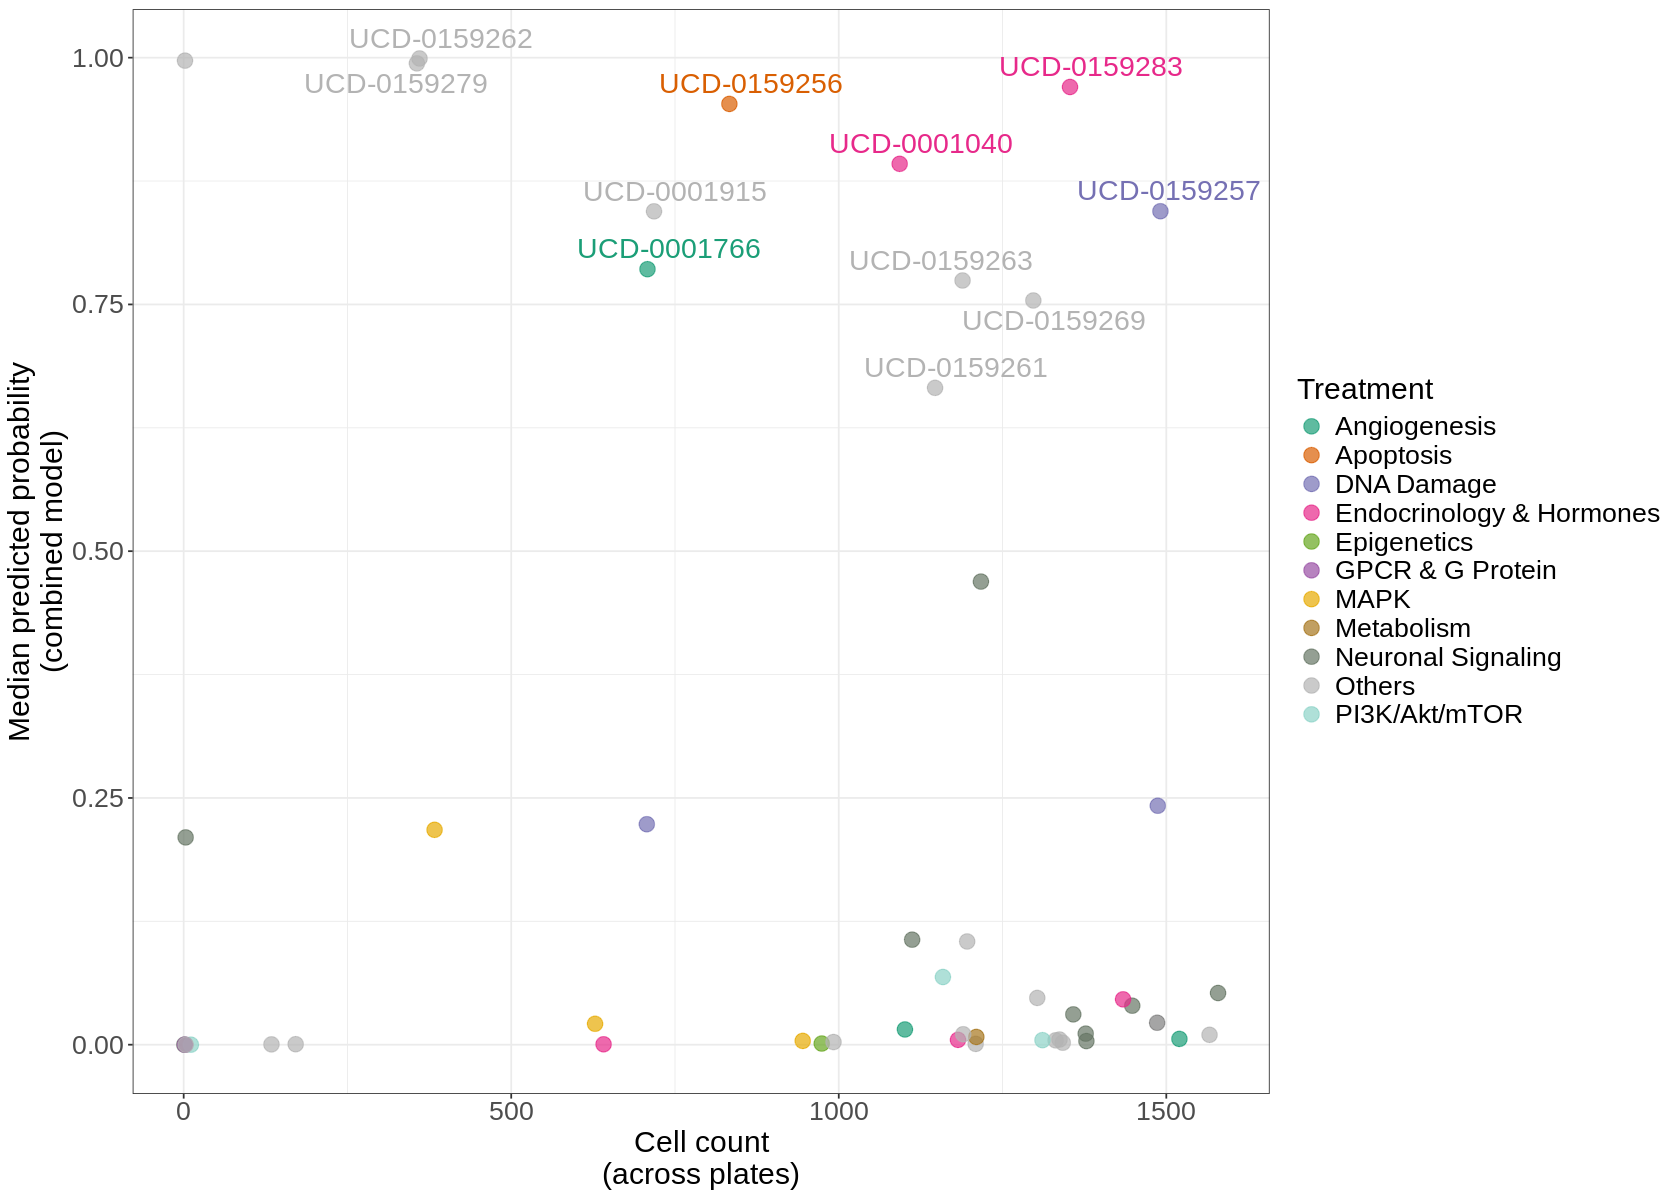

In [6]:
# Custom color palette inspired by Dark2 (includes one more color for a pathway missing in above plot)
custom_palette <- c(
  "Angiogenesis" = "#1b9e77",
  "Apoptosis" = "#d95f02",
  "DNA Damage" = "#7570b3",
  "Endocrinology & Hormones" = "#e7298a",
  "Epigenetics" = "#66a61e",
  "MAPK" = "#e6ab02",
  "Metabolism" = "#a6761d",
  "Neuronal Signaling" = "#667665",
  "Others" = "#b3b3b3",
  "PI3K/Akt/mTOR" = "#8dd3c7",
  "Stem Cells &  Wnt" = "#fb8072",
  "GPCR & G Protein" = "#984ea3"
)

height <- 10
width <- 14
options(repr.plot.width = width, repr.plot.height = height)

# Generate scatterplot for probability and cell count
count_probas_plot <- ggplot(summary_data, aes(x = cell_count, y = median_predicted_proba, color = Metadata_Pathway)) +
    geom_point(size = 4, alpha = 0.7) +
    geom_text_repel(data = subset(summary_data, high_count_and_proba == TRUE), aes(label = Metadata_treatment), 
                    size = 6, box.padding = 0.35, point.padding = 0.5, max.overlaps = 20, show.legend = FALSE) +  # Add labels
    scale_color_manual(values = custom_palette) +  # Use the custom color palette
    labs(
        x = "Cell count\n(across plates)",
        y = "Median predicted probability\n(combined model)",
        color = "Treatment",
    ) +
    theme_bw() +
    theme(
        legend.position = "right",
        legend.title = element_text(size = 18),
        legend.text = element_text(size = 16),
        axis.text = element_text(size = 16),
        axis.title = element_text(size = 18)
    )

# Save the scatterplot
ggsave(paste0(figures_dir, "/batch1_median_proba_vs_cell_count_compounds.png"), count_probas_plot, height = height, width = width, dpi = 500)

count_probas_plot

## Generate scatterplot with mAP negative and positive control scores

In [7]:
# Read in the mAP scores CSV file
mAP_scores_path <- "./_all_mAP_scores.csv"
mAP_scores <- read.csv(mAP_scores_path)
mAP_scores <- dplyr::filter(mAP_scores, shuffled == "False") # Filter only for non-shuffled results

# Set treatment as a character to match for merging
summary_data$Metadata_treatment <- as.character(summary_data$Metadata_treatment)

# Merge the mAP scores with the summary_data using the Metadata_treatment column
summary_data_w_mAP <- summary_data %>%
    left_join(mAP_scores %>% select(Metadata_treatment, negative_mean_average_precision, positive_mean_average_precision), 
        by = "Metadata_treatment")

# Drop rows with NaNs in the mAP scores
summary_data_w_mAP <- summary_data_w_mAP %>%
  filter(!is.na(negative_mean_average_precision) & !is.na(positive_mean_average_precision))


# Display the updated summary_data
dim(summary_data_w_mAP)
head(summary_data_w_mAP)

[1] 49  7

Metadata_treatment,median_predicted_proba,cell_count,Metadata_Pathway,high_count_and_proba,negative_mean_average_precision,positive_mean_average_precision
<chr>,<dbl>,<int>,<chr>,<lgl>,<dbl>,<dbl>
UCD-0159290,1.080342e-07,11,PI3K/Akt/mTOR,FALSE,1.0000000,1.000000
UCD-0018091,1.551100e-14,2,GPCR & G Protein,FALSE,1.0000000,1.000000
UCD-0159286,5.292947e-04,171,Others,FALSE,0.5106610,0.650903
UCD-0001801,4.450906e-04,641,Endocrinology & Hormones,FALSE,1.0000000,1.000000
UCD-0001844,3.487139e-04,134,Others,FALSE,1.0000000,1.000000
UCD-0159271,8.214557e-04,1209,Others,FALSE,0.7599528,1.000000


In [8]:
setdiff(summary_data$Metadata_treatment, mAP_scores$Metadata_treatment)

[1] "UCD-0000721"

We lose one compound when adding mAP scores do to very low cell count.

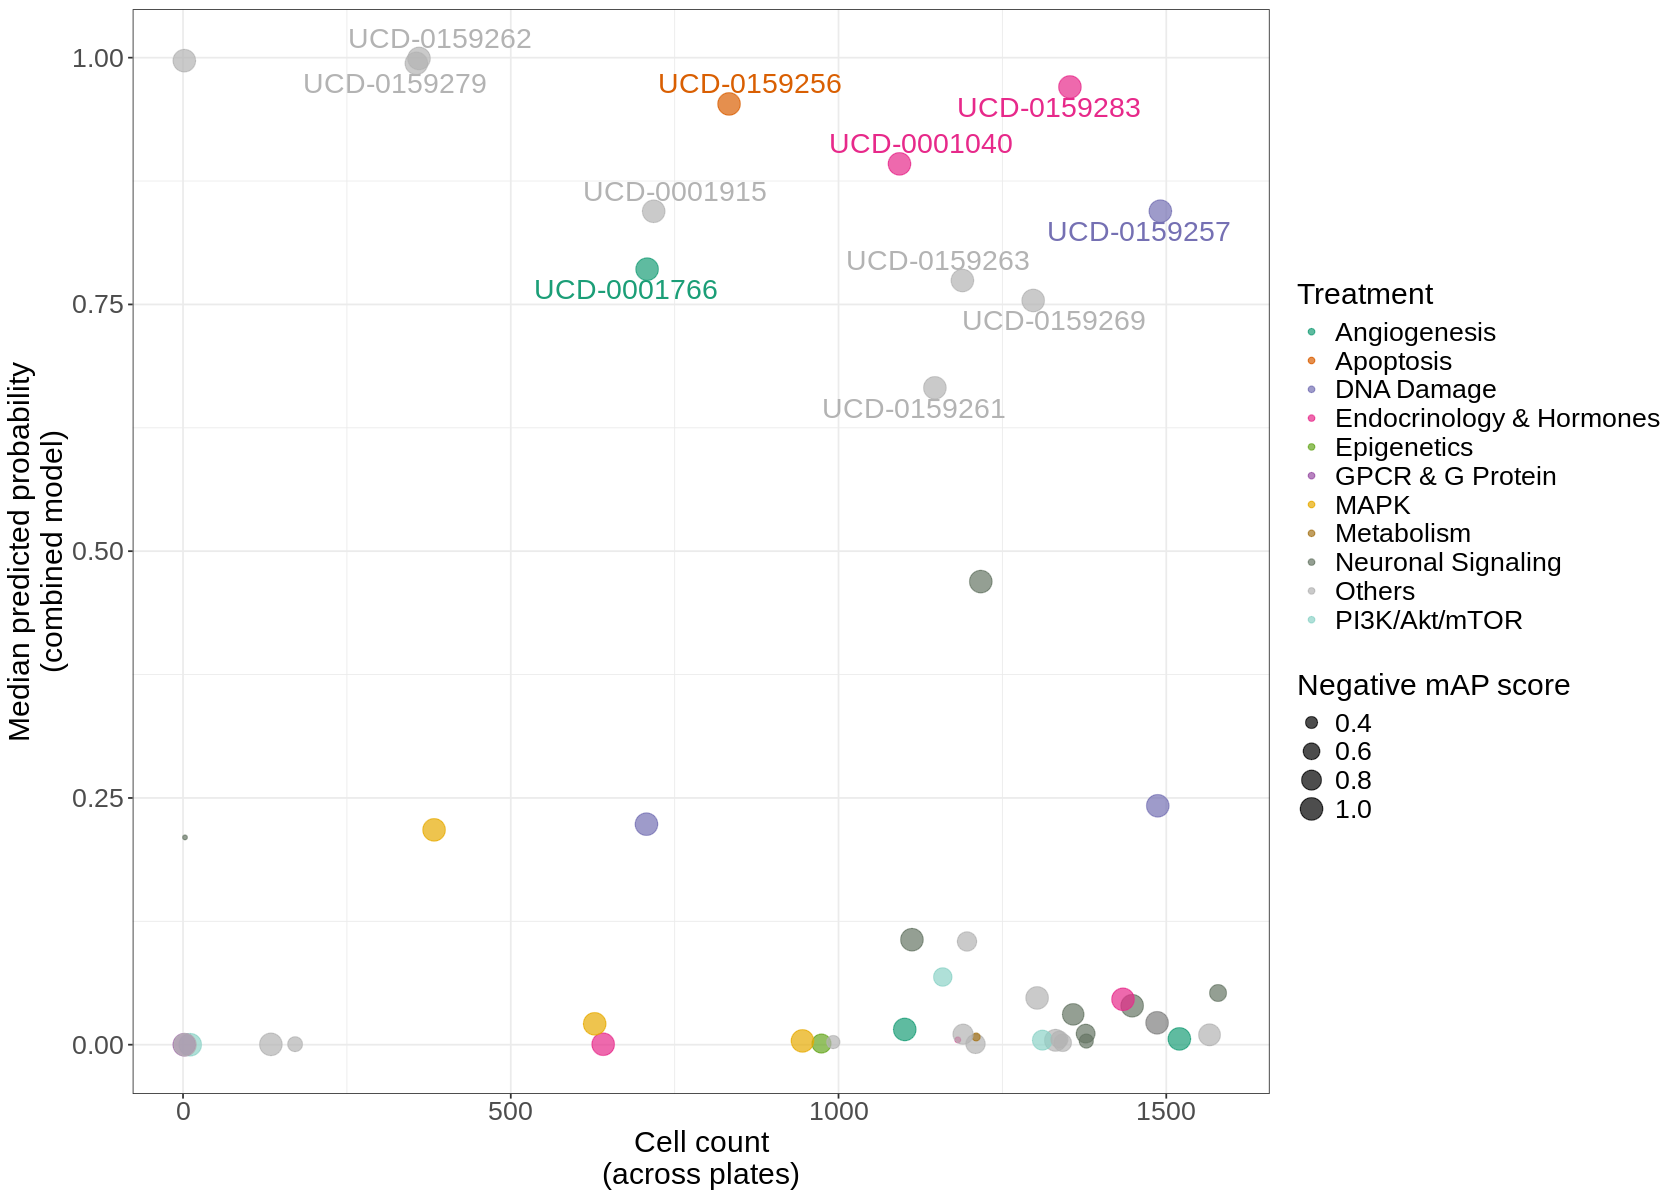

In [9]:
height <- 10
width <- 14
options(repr.plot.width = width, repr.plot.height = height)

# Generate scatterplot for probability and cell count
count_probas_plot <- ggplot(summary_data_w_mAP, aes(x = cell_count, y = median_predicted_proba, color = Metadata_Pathway)) +
    geom_point(aes(size = negative_mean_average_precision), alpha = 0.7) +
    geom_text_repel(data = subset(summary_data, high_count_and_proba == TRUE), aes(label = Metadata_treatment), 
                    size = 6, box.padding = 0.35, point.padding = 0.5, max.overlaps = 20, show.legend = FALSE) +  # Add labels
    scale_color_manual(values = custom_palette) +  # Use the custom color palette
    scale_size_continuous(name = "Negative mAP score") +
    labs(
        x = "Cell count\n(across plates)",
        y = "Median predicted probability\n(combined model)",
        color = "Treatment",
    ) +
    theme_bw() +
    theme(
        legend.position = "right",
        legend.title = element_text(size = 18),
        legend.text = element_text(size = 16),
        axis.text = element_text(size = 16),
        axis.title = element_text(size = 18)
    )

# Save the scatterplot
ggsave(paste0(figures_dir, "/batch1_neg_mAP_median_proba_vs_cell_count_compounds.png"), count_probas_plot, height = height, width = width, dpi = 500)

count_probas_plot

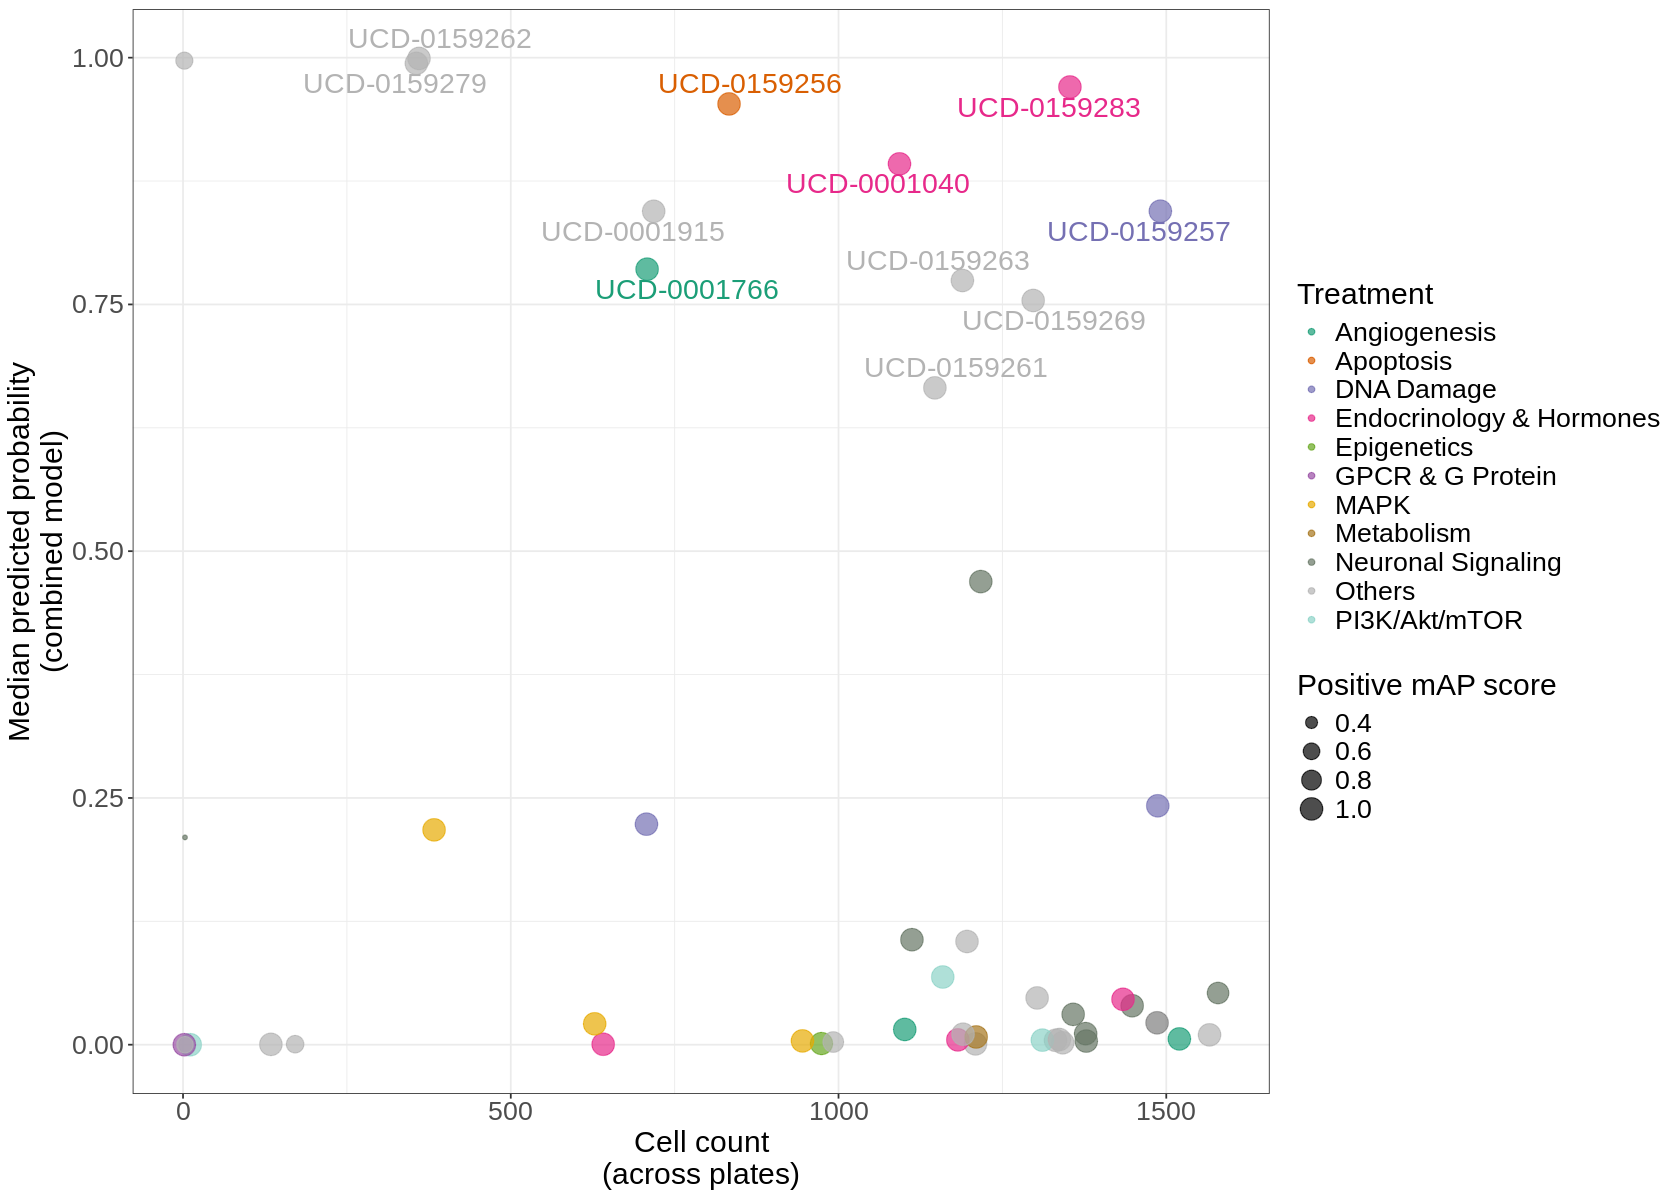

In [10]:
height <- 10
width <- 14
options(repr.plot.width = width, repr.plot.height = height)

# Generate scatterplot for probability and cell count
count_probas_plot <- ggplot(summary_data_w_mAP, aes(x = cell_count, y = median_predicted_proba, color = Metadata_Pathway)) +
    geom_point(aes(size = positive_mean_average_precision), alpha = 0.7) +
    geom_text_repel(data = subset(summary_data, high_count_and_proba == TRUE), aes(label = Metadata_treatment), 
                    size = 6, box.padding = 0.35, point.padding = 0.5, max.overlaps = 20, show.legend = FALSE) +  # Add labels
    scale_color_manual(values = custom_palette) +  # Use the custom color palette
    scale_size_continuous(name = "Positive mAP score") +
    labs(
        x = "Cell count\n(across plates)",
        y = "Median predicted probability\n(combined model)",
        color = "Treatment",
    ) +
    theme_bw() +
    theme(
        legend.position = "right",
        legend.title = element_text(size = 18),
        legend.text = element_text(size = 16),
        axis.text = element_text(size = 16),
        axis.title = element_text(size = 18)
    )

# Save the scatterplot
ggsave(paste0(figures_dir, "/batch1_pos_mAP_median_proba_vs_cell_count_compounds.png"), count_probas_plot, height = height, width = width, dpi = 500)

count_probas_plot